# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
    """
Steering angle prediction model
"""

#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize
from sklearn.utils import shuffle
import cv2

import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
import csv
import cv2
import numpy as np
dir = 'mydata'
lines = []
with open(dir + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        lines.append(line)

imagesC = []
imagesL = []
imagesR = []
measurements = []
i = 0;
for line in lines:
    source_path = line[0]
    filenameC = source_path.split('/')[-1]
    current_path = dir + '/IMG/' + filenameC
    imageC = cv2.imread(current_path)
    imagesC.append(imageC)
    source_pathL = line[1]
    filenameL = source_pathL.split('/')[-1]
    current_path = dir + '/IMG/' + filenameL
    imageL = cv2.imread(current_path)
    imagesL.append(imageL)
    source_pathR = line[2]
    filenameR = source_pathR.split('/')[-1]
    current_path = dir + '/IMG/' + filenameR
    imageR = cv2.imread(current_path)
    imagesR.append(imageR)
    measurement = float(line[3])
    measurements.append(measurement)


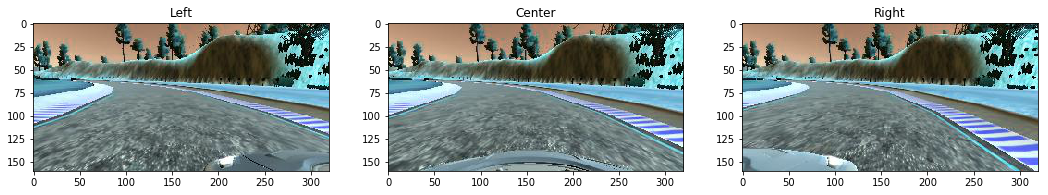

In [3]:
import matplotlib.pyplot as plt

imageC0 = imagesC[0]
imageL0 = imagesL[0]
imageR0 = imagesR[0]

plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('Left')
plt.imshow(imageL0)
plt.subplot(132)
plt.title('Center')
plt.imshow(imageC0)
plt.subplot(133)
plt.title('Right')
plt.imshow(imageR0)
plt.savefig('examples/orig-left-center-right.png')

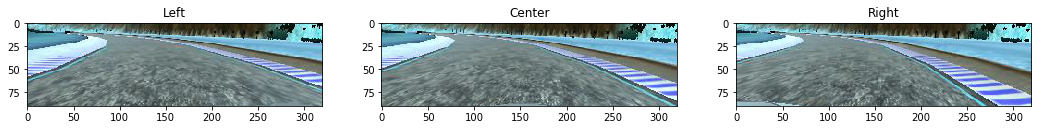

In [4]:
crop_start = 50
crop_end = 140
crop_imageL0 = imageL0[crop_start:crop_end, :]
crop_imageC0 = imageC0[crop_start:crop_end, :]
crop_imageR0 = imageR0[crop_start:crop_end, :]
#crop_imageR0 = cv2.resize(crop_imageR0, (320, 160), interpolation = cv2.INTER_LINEAR)
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('Left')
plt.imshow(crop_imageL0)
plt.subplot(132)
plt.title('Center')
plt.imshow(crop_imageC0)
plt.subplot(133)
plt.title('Right')
plt.imshow(crop_imageR0)
crop_imageL0.shape
plt.savefig('examples/crop-left-center-right.png')

In [5]:
# Make the model and run it.
def check_good_steering_angle(yi): 
    probability = random.random()
    if (probability > 0.5 or abs(yi) > 0.01):
       return True
    else:
        return False


In [6]:
# Fill the samples array. Skip the first line.
samples = []
linec = 0
with open(dir + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(linec > 0):
            samples.append(line)
        linec = linec + 1

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('Train size ', len(train_samples))
print('Valid size ', len(validation_samples))

# Reduce the pictures with low steering angles.
good_train_samples = []
 
for tsam in train_samples:
    name = dir + '/IMG/' + tsam[0].split('/')[-1]
    center_angle = float(tsam[3])
    if(check_good_steering_angle(center_angle)):
#        print('Steering ', center_angle, tsam[0])
        good_train_samples.append(tsam)

print('Good train size ', len(good_train_samples))
train_samples = good_train_samples



Train size  2033
Valid size  509
Good train size  1317


In [7]:
trans_range = 100
crop_imageL0.shape

def trans_image(image,steer):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer - tr_x/trans_range*2*.2
    tr_y = 0
    rows, cols, ch = image.shape
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    return image_tr,steer_ang

def flip_image(image):
    flipimage = np.fliplr(image)
    return flipimage



Shape  (90, 320, 3)  Steer  -0.10225166877863545


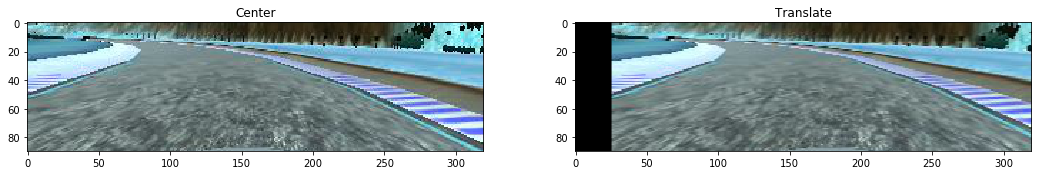

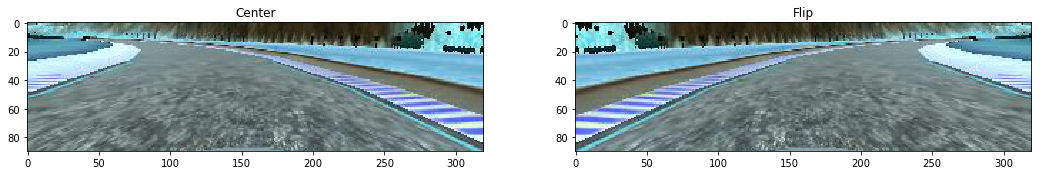

In [8]:
sangle = measurements[0]
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title('Center')
plt.imshow(crop_imageC0)
timage, steer = trans_image(crop_imageC0, sangle)
print('Shape ', timage.shape, ' Steer ', steer)
plt.subplot(122)
plt.title('Translate')
plt.imshow(timage)
plt.savefig('examples/translate-center.png')

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title('Center')
plt.imshow(crop_imageC0)
plt.subplot(122)
plt.title('Flip')
plt.imshow(flip_image(crop_imageC0))
plt.savefig('examples/flip-center.png')

In [9]:
import cv2
import numpy as np
import sklearn
from keras.layers import Cropping2D, Input, Dense
from keras.models import Model

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                cname = dir + '/IMG/'+batch_sample[0].split('/')[-1]
                lname = dir + '/IMG/'+batch_sample[1].split('/')[-1]
                rname = dir + '/IMG/'+batch_sample[2].split('/')[-1]
                sangle = float(batch_sample[3])
                choice = random.randrange(1,4)
                good_steer = (sangle < -zero_steer and sangle > float('-inf') ) or (sangle > zero_steer and sangle < float('inf'))
                if(good_steer):
                    if(choice == 1):
                        use_angle = sangle
                        use_image = cv2.imread(cname)
                    elif(choice == 2):
                        use_angle = sangle - correction
                        use_image = cv2.imread(rname)
                    elif(choice == 3):
                        use_angle = sangle + correction
                        use_image = cv2.imread(lname)
                    else:
                        use_angle = -sangle
                        use_image = flip_image(cv2.imread(cname))
                else:
                    use_image, use_angle = trans_image(cv2.imread(cname), sangle)

                images.append(use_image)
                angles.append(use_angle)
 
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)


In [10]:
# 
# Simple setup of the training samples without the use of the generator.
#
X_t = []
m_t = []
X_train = []
correction = 0.25
zero_steer = 0.1
dsize = len(imagesC)
#
# For all the images read in from the driving_log.csv 
#
for i in range(0, dsize):
    #
    # Give priority to all the images when the steering angle is above a threshold
    #
    sa = measurements[i]
    good_steer = (sa < -zero_steer and sa > float('-inf') ) or (sa > zero_steer and sa < float('inf'))
    if(good_steer or random.random() > 0.9) :
        #
        # Use cases where the steering angle is above threshold or cases with zero steer with a probability of 10%  
        #
        X_t.append(imagesC[i])
        m_t.append(sa)
        X_t.append(flip_image(imagesC[i]))
        m_t.append(-sa)
        X_t.append(imagesL[i])
        m_t.append(sa+correction)
        X_t.append(imagesR[i])
        m_t.append(sa-correction)
    else:
        #
        # When the steering angle is close to zero, add a random translation to the left or right and use it.
        #
        use_image, use_angle = trans_image(imagesC[i], sa)
        X_t.append(use_image)
        m_t.append(use_angle)


X_train = np.array(X_t)
y_train = np.array(m_t)
    

Train on 3687 samples, validate on 922 samples
Epoch 1/3
3687/3687 [==============================] - 9s - loss: 0.0434 - val_loss: 0.0563
Epoch 2/3
3687/3687 [==============================] - 7s - loss: 0.0277 - val_loss: 0.0345
Epoch 3/3
3687/3687 [==============================] - 7s - loss: 0.0245 - val_loss: 0.0392
dict_keys(['loss', 'val_loss'])


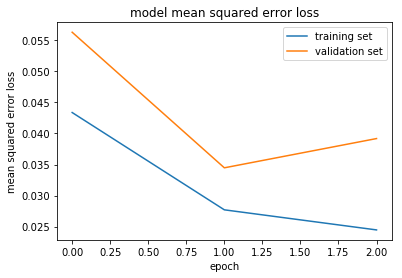

In [11]:
#
# Set this variable to start a model if it is set to false it will load the current model and improve it.
#
make_model = True
#
# Set the cropping window size to limit view to the relevant road only.
#
chs, rows, cols = 3, 90, 320  
#
# Make the model resemble the NVIDIA model
#
model = Sequential()
#
# Crop the image to only consider the region of interest which concentrates on the road ahead.
#
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
#
# Normalize all the pixels to -0.5 to +0.5
#
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(rows, cols, chs), output_shape=(rows, cols, chs)))
#
# Add a 5x5 Convolution layer and MaxPool the output.
#
model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='same', activation="relu"))
model.add(MaxPooling2D())
#
# Add a second 5x5 Convolution layer.
#
model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='same', activation="relu"))
#model.add(MaxPooling2D())
#
# Add a third 5x5 Convolution layer.
#
model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode='same', activation="relu"))
model.add(MaxPooling2D())
#
# Add a fourth 3x3 Convolution layer.
#
model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='same', activation="relu"))
#
# Add a fifth 3x3 Convolution layer.
#
model.add(Convolution2D(64, 3, 3, subsample=(1,1), border_mode='same', activation="relu"))
#
# Flatten the image from the convolution layer.
#
model.add(Flatten())
#
# Add a dropout layer to make the learning robust to missing data.
# 
model.add(Dropout(0.5))    
#
# Add a Dense layer with output size 1164 feeding into an exponential linear unit
# 
model.add(Dense(1164))
model.add(ELU())
#
# Add a dropout layer to make the learning robust to missing data.
# 
model.add(Dropout(0.5))    
#
# Add a Dense layer with output size 100 feeding into an exponential linear unit
# 
model.add(Dense(100))
model.add(ELU())
#
# Add a dropout layer to make the learning robust to missing data.
#  
model.add(Dropout(0.5))    
#
# Add a Dense layer with output size 50 feeding into an exponential linear unit
# 
model.add(Dense(50))
model.add(ELU())
#
# Final output layer
# 
model.add(Dense(1))
#
# Use this branch when starting out with no model.
#
if(make_model):
    model.compile(loss='mse', optimizer='adam')
else:
    #
    # This code is used when the model is already present and needs to be improved with the new data.
    # 
    from keras.models import load_model
    model = load_model('model-mydata-best.h5')
    keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='mse', optimizer='adam')
#
# Fit the data into the model and save the history of the loss for both training and validation to graph later.
#
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3)

#history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
#            validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5)

#
# Save the model.
#
model.save('model.h5')
#
# print the keys contained in the history object
#
print(history_object.history.keys())
#
# plot the training and validation loss for each epoch
#
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.savefig('examples/loss-mse.png')

#Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas